1.

a. θ = (XᵀX)<sup>-1</sup>Xᵀy

b-c. При добавлении L1 регуляризации в функцию потерь мы добавляем сумму всех весов к функции потерь, она зануляет слишком маленькие веса.

При добавлении L2 регуляризации в функцию потерь мы добавляем сумму квадратов всех весов к функции потерь, она равномерно уменьшает все веса, и штрафунт слишком большие веса.

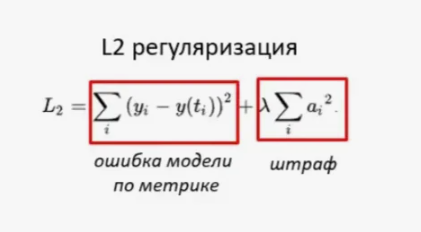

Чтобы обеспечить возможность подбора нелинейных зависимостей можно намример добавить возвести в степень признаки при помощи PolynomialFeatures
Было: y = w₀ + w₁*x
Стало: y = w₀ + w₁*x + w₂*x² + w₃*x³

2. Предварительная обработка из предыдущего урока

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns

In [2]:
df1 = pd.read_json('train.json')

print(f'Кол-во строк и столбцов: {df1.shape}\n')
print(df1.columns, '\n')

Кол-во строк и столбцов: (49352, 15)

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level'],
      dtype='object') 



In [3]:
df = df1.copy()
df['interest_level'] = df['interest_level'].replace({
    'low': 0,
    'medium': 1,
    'high': 2
})
df['interest_level'].value_counts()

/tmp/ipython-input-3395325694.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['interest_level'] = df['interest_level'].replace({


,count
interest_level,
0,34284
1,11229
2,3839


In [4]:
lower_bound = df['price'].quantile(0.01)
upper_bound = df['price'].quantile(0.99)
df = df[(df['price']>lower_bound) & (df['price']<upper_bound)]

In [5]:
"""from sklearn import datasets

diabetes = datasets.load_diabetes()

X = diabetes.data
y = diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)"""

'from sklearn import datasets\n\ndiabetes = datasets.load_diabetes()\n\nX = diabetes.data\ny = diabetes.target\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)'

3. Вводный анализ данных.

In [6]:
import pandas as pd
from collections import Counter

df['features_clean'] = df['features'].apply(
    lambda feature_list: [
        feature.replace('[', '').replace(']', '').replace("'", "").replace('"', '').replace(' ', '')
        for feature in feature_list
    ]
)

all_features = []
for idx, row in df.iterrows():
    all_features.extend(row['features_clean'])

unique_count = len(set(all_features))
print(f"Уникальных фич: {unique_count}")

top_20 = Counter(all_features).most_common(20)
print("\nТоп-20 самых частых фич:\n")
for feat, count in top_20:
    print(f"{feat}: {count}")


Уникальных фич: 1529

Топ-20 самых частых фич:

Elevator: 25375
HardwoodFloors: 23146
CatsAllowed: 23135
DogsAllowed: 21652
Doorman: 20479
Dishwasher: 20081
NoFee: 17793
LaundryinBuilding: 16082
FitnessCenter: 12989
Pre-War: 8971
LaundryinUnit: 8437
RoofDeck: 6417
OutdoorSpace: 5132
DiningRoom: 4890
HighSpeedInternet: 4223
Balcony: 2898
SwimmingPool: 2643
LaundryInBuilding: 2564
NewConstruction: 2504
Terrace: 2177


In [7]:
X = pd.DataFrame()
y = df['price']
top_20_list = [i[0] for i in top_20]
for feat in top_20_list:
    X[feat] = df["features_clean"].apply(lambda x: int(feat in x))

feature_list = top_20_list + ['bathrooms', 'bedrooms']
X[['bathrooms', 'bedrooms']] = df[['bathrooms', 'bedrooms']]


In [8]:
print(X.shape)
print(X.head())

(48343, 22)
    Elevator  HardwoodFloors  CatsAllowed  DogsAllowed  Doorman  Dishwasher  \
4          0               1            1            1        0           1   
6          1               1            0            0        1           1   
9          1               1            0            0        1           1   
10         0               0            0            0        0           0   
15         1               0            0            0        1           0   

    NoFee  LaundryinBuilding  FitnessCenter  Pre-War  ...  OutdoorSpace  \
4       0                  1              0        1  ...             0   
6       1                  1              0        0  ...             0   
9       0                  1              0        0  ...             0   
10      0                  0              0        0  ...             0   
15      0                  1              1        0  ...             0   

    DiningRoom  HighSpeedInternet  Balcony  SwimmingPool  Laun

4. Реализация моделей — Линейная регрессия

Аналитическое решение (МНК) и Градиентный спуск

In [9]:
np.random.seed(21)


class LinearRegressionAnalytical:
    """Линейная регрессия с аналитическим решением"""
    def __init__(self):
        self.weights = None

    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        # w = (XᵀX)^(-1) Xᵀy
        self.weights = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b @ self.weights


class LinearRegressionGD:
    """Линейная регрессия с обычным (batch) градиентным спуском"""
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        X_b = np.c_[np.ones((n_samples, 1)), X]
        self.weights = np.zeros(X_b.shape[1])

        for _ in range(self.n_iters):
            y_pred = X_b @ self.weights
            gradient = (1/n_samples) * X_b.T @ (y_pred - y)
            self.weights = self.weights - self.lr * gradient

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b @ self.weights

Стохастический градиентный спуск (SGD)

In [10]:
class LinearRegressionSGD:
    """Линейная регрессия со стохастическим градиентным спуском (SGD)"""
    def __init__(self, lr=0.01, n_epochs=50, random_state=21):
        self.lr = lr
        self.n_epochs = n_epochs
        self.weights = None
        self.random_state = random_state

    def fit(self, X, y):
        np.random.seed(self.random_state)
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        X_b = np.c_[np.ones((n_samples, 1)), X]
        self.weights = np.zeros(X_b.shape[1])

        for epoch in range(self.n_epochs):
            indices = np.random.permutation(n_samples)
            X_b_shuffled = X_b[indices]
            y_shuffled = y[indices]

            for i in range(n_samples):
                xi = X_b_shuffled[i:i+1]
                yi = y_shuffled[i]
                gradient = xi.T @ (xi @ self.weights - yi)
                self.weights = self.weights - self.lr * gradient

    def predict(self, X):
        X = np.array(X)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b @ self.weights


 Коэффициент детерминации (R2)

In [11]:
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot

Функция: обучает модели и добавляет метрики в таблицу

In [12]:
def models_metrics(models, X_train, y_train, X_test, y_test, result_MAE, result_RMSE, result_R2):
    for name, model in models.items():
        model.fit(X_train, y_train)
        predict_test = model.predict(X_test)
        predict_train = model.predict(X_train)

        new_result_MAE = pd.DataFrame({'model': [name],
                                    'train': [mean_absolute_error(y_train, predict_train)],
                                    'test': [mean_absolute_error(y_test, predict_test)]})

        new_result_RMSE = pd.DataFrame({
                                    'model': [name],
                                    'train': [mean_squared_error(y_train, predict_train) ** 0.5],
                                    'test': [mean_squared_error(y_test, predict_test) ** 0.5]})

        new_result_R2 = pd.DataFrame({'model': [name],
                                        'train': [r2_score(y_train, predict_train)],
                                        'test': [r2_score(y_test, predict_test)]})

        result_MAE = pd.concat([result_MAE, new_result_MAE], ignore_index=True)
        result_RMSE = pd.concat([result_RMSE, new_result_RMSE], ignore_index=True)
        result_R2 = pd.concat([result_R2, new_result_R2], ignore_index=True)

    return result_MAE, result_RMSE, result_R2

Метрики:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
print(y_train.describe())
print(y_test.describe())

count    38674.000000
mean      3535.823783
std       1580.481110
min       1485.000000
25%       2500.000000
50%       3150.000000
75%       4065.000000
max      12995.000000
Name: price, dtype: float64
count     9669.000000
mean      3532.541111
std       1606.117082
min       1489.000000
25%       2495.000000
50%       3147.000000
75%       4050.000000
max      12995.000000
Name: price, dtype: float64


In [14]:
result_MAE = pd.DataFrame(columns=['model', 'train', 'test'])
result_RMSE = pd.DataFrame(columns=['model', 'train', 'test'])
result_R2 = pd.DataFrame(columns=['model', 'train', 'test'])

In [15]:
lr_my = LinearRegressionSGD()
lr_sk = LinearRegression()

models = {'linear_regression_sklear': lr_sk, 'linear_regression_my': lr_my}

result_MAE, result_RMSE, result_R2 = models_metrics(models, X_train, y_train, X_test, y_test, result_MAE, result_RMSE, result_R2)

/tmp/ipython-input-924145716.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_MAE = pd.concat([result_MAE, new_result_MAE], ignore_index=True)
/tmp/ipython-input-924145716.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_RMSE = pd.concat([result_RMSE, new_result_RMSE], ignore_index=True)
/tmp/ipython-input-924145716.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty

In [16]:
print(f'MAE:\n {result_MAE}\n')
print(f'RMSE:\n {result_RMSE}\n')
print(f'R2:\n {result_R2}\n')

MAE:
                       model       train        test
0  linear_regression_sklear  708.494998  709.678526
1      linear_regression_my  761.484910  765.712253

RMSE:
                       model        train         test
0  linear_regression_sklear  1028.253868  1023.842890
1      linear_regression_my  1062.928904  1062.966007

R2:
                       model     train      test
0  linear_regression_sklear  0.576715  0.593597
1      linear_regression_my  0.547685  0.561944



5. Реализация регуляризованных моделей - Ridge, Lasso, ElasticNet

In [17]:
class LinearRegressionRegularized:
    """Линейная регрессия со стохастическим градиентным спуском (SGD) + L1 + L2 (ElasticNet)"""
    def __init__(self, lr=0.01, n_epochs=50,
                 alpha_l1=0.0, alpha_l2=0.0, random_state=21):
        self.lr = lr
        self.n_epochs = n_epochs
        self.alpha_l1 = alpha_l1
        self.alpha_l2 = alpha_l2
        self.weights = None
        self.random_state = random_state

    def fit(self, X, y):
        np.random.seed(self.random_state)
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        X_b = np.c_[np.ones((n_samples, 1)), X]
        self.weights = np.zeros(X_b.shape[1])

        for epoch in range(self.n_epochs):
            indices = np.random.permutation(n_samples)
            X_b_shuffled = X_b[indices]
            y_shuffled = y[indices]

            for i in range(n_samples):
                xi = X_b_shuffled[i:i+1]
                yi = y_shuffled[i]

                grad = xi.T @ (xi @ self.weights - yi)
                grad[1:] += self.alpha_l2 * self.weights[1:]
                grad[1:] += self.alpha_l1 * np.sign(self.weights[1:])
                self.weights = self.weights - self.lr * grad

    def predict(self, X):
        X = np.array(X)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b @ self.weights


In [18]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [19]:
lasso = Lasso(alpha=0.1)
lasso_my = LinearRegressionRegularized(alpha_l1=0.1)
ridge = Ridge(alpha=0.1)
ridge_my = LinearRegressionRegularized(alpha_l2=0.1)
elasticnet = ElasticNet(alpha=0.2, l1_ratio=0.5)
elasticnet_my = LinearRegressionRegularized(alpha_l1=0.1, alpha_l2=0.1)

models = {'Lasso_sk': lasso, 'Lasso_my' : lasso_my, 'Ridge_sk': ridge, 'Ridge_my' : ridge_my, 'ElasticNet_sk' : elasticnet, 'ElasticNet_my' : elasticnet_my}

result_MAE, result_RMSE, result_R2 = models_metrics(models, X_train, y_train, X_test, y_test, result_MAE, result_RMSE, result_R2)

print(f'MAE:\n {result_MAE}\n')
print(f'RMSE:\n {result_RMSE}\n')
print(f'R2:\n {result_R2}\n')

MAE:
                       model       train        test
0  linear_regression_sklear  708.494998  709.678526
1      linear_regression_my  761.484910  765.712253
2                  Lasso_sk  708.436256  709.651870
3                  Lasso_my  761.507548  765.760335
4                  Ridge_sk  708.494658  709.678409
5                  Ridge_my  797.323971  806.175753
6             ElasticNet_sk  725.720981  730.367013
7             ElasticNet_my  797.409063  806.260690

RMSE:
                       model        train         test
0  linear_regression_sklear  1028.253868  1023.842890
1      linear_regression_my  1062.928904  1062.966007
2                  Lasso_sk  1028.255864  1023.865014
3                  Lasso_my  1062.969874  1063.042103
4                  Ridge_sk  1028.253868  1023.843227
5                  Ridge_my  1101.146794  1107.782873
6             ElasticNet_sk  1063.329288  1067.006242
7             ElasticNet_my  1101.221694  1107.873356

R2:
                       mode

6. Нормализация функций

Нормализация обязательна, когда применяются алгоритмы, чувствительные к масштабу:

Градиентный спуск (скорость сходимости) (как в нашем случае)

K-Means (расстояния между точками)

SVM (ширина разделяющей полосы)

KNN (евклидовы расстояния)

Также она нужна когда признаки слишком разные нампример одни в сотнях, другие в сотнях тысяч

(например в деревьях нормализация не нужна)

И для регуляризации нужны одинаковые по масштабу признаки

MinMaxScaler Формула:

X_scaled = (X - X_min) / (X_max - X_min)

In [20]:
class MinMaxScalerMy:
    def __init__(self, feature_range=(0, 1)):
        self.feature_range = feature_range
        self.data_min_ = None
        self.data_max_ = None
        self.scale_ = None
        self.min_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=float)
        self.data_min_ = X.min(axis=0)
        self.data_max_ = X.max(axis=0)
        data_range = self.data_max_ - self.data_min_

        scale = (self.feature_range[1] - self.feature_range[0]) / np.where(data_range != 0, data_range, 1)
        min_ = self.feature_range[0] - self.data_min_ * scale

        self.scale_ = scale
        self.min_ = min_
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return X * self.scale_ + self.min_

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [21]:
X2 = X.copy()
scaler = MinMaxScaler()
X2_scaled = scaler.fit_transform(X2)

X3 = X.copy()
scaler_my = MinMaxScalerMy()
X3_scaled = scaler_my.fit_transform(X3)

pd.DataFrame(X2_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.125
1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.250
2,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.250
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.375
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.000


In [22]:
pd.DataFrame(X3_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.125
1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.250
2,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.250
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.375
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.000


На обоих скалерах значения одинаковые

StandardScaler Формула:

X_scaled = (X - X_mean) / X_std

X_std - стандартное отклонение

In [23]:
class StandardScalerMy:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=float)
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0, ddof=0)
        self.scale_[self.scale_ == 0] = 1
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [24]:
X4 = X.copy()
scaler = StandardScaler()
X4_scaled = scaler.fit_transform(X4)

X5 = X.copy()
scaler_my = StandardScalerMy()
X5_scaled = scaler_my.fit_transform(X5)

pd.DataFrame(X4_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-1.051094,1.043365,1.043841,1.110282,-0.857300,1.186339,-0.763166,1.416344,-0.606134,2.094948,...,-0.344625,2.980955,-0.30938,-0.252526,-0.240486,-0.236661,-0.233722,-0.217154,-0.427289,-0.485075
1,0.951390,1.043365,-0.958000,-0.900672,1.166453,1.186339,1.310331,1.416344,-0.606134,-0.477339,...,-0.344625,-0.335463,-0.30938,-0.252526,-0.240486,-0.236661,-0.233722,-0.217154,-0.427289,0.422959
2,0.951390,1.043365,-0.958000,-0.900672,1.166453,1.186339,-0.763166,1.416344,-0.606134,-0.477339,...,-0.344625,-0.335463,-0.30938,-0.252526,-0.240486,-0.236661,-0.233722,-0.217154,-0.427289,0.422959
3,-1.051094,-0.958437,-0.958000,-0.900672,-0.857300,-0.842929,-0.763166,-0.706043,-0.606134,-0.477339,...,-0.344625,-0.335463,-0.30938,-0.252526,-0.240486,-0.236661,-0.233722,-0.217154,0.670290,1.330994
4,0.951390,-0.958437,-0.958000,-0.900672,1.166453,-0.842929,-0.763166,1.416344,1.649800,-0.477339,...,-0.344625,-0.335463,-0.30938,-0.252526,-0.240486,-0.236661,-0.233722,-0.217154,-0.427289,-1.393110


In [25]:
pd.DataFrame(X5_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-1.051094,1.043365,1.043841,1.110282,-0.857300,1.186339,-0.763166,1.416344,-0.606134,2.094948,...,-0.344625,2.980955,-0.30938,-0.252526,-0.240486,-0.236661,-0.233722,-0.217154,-0.427289,-0.485075
1,0.951390,1.043365,-0.958000,-0.900672,1.166453,1.186339,1.310331,1.416344,-0.606134,-0.477339,...,-0.344625,-0.335463,-0.30938,-0.252526,-0.240486,-0.236661,-0.233722,-0.217154,-0.427289,0.422959
2,0.951390,1.043365,-0.958000,-0.900672,1.166453,1.186339,-0.763166,1.416344,-0.606134,-0.477339,...,-0.344625,-0.335463,-0.30938,-0.252526,-0.240486,-0.236661,-0.233722,-0.217154,-0.427289,0.422959
3,-1.051094,-0.958437,-0.958000,-0.900672,-0.857300,-0.842929,-0.763166,-0.706043,-0.606134,-0.477339,...,-0.344625,-0.335463,-0.30938,-0.252526,-0.240486,-0.236661,-0.233722,-0.217154,0.670290,1.330994
4,0.951390,-0.958437,-0.958000,-0.900672,1.166453,-0.842929,-0.763166,1.416344,1.649800,-0.477339,...,-0.344625,-0.335463,-0.30938,-0.252526,-0.240486,-0.236661,-0.233722,-0.217154,-0.427289,-1.393110


На обоих скалерах значения одинаковые

7. Подгонка пользовательских моделей и моделей sklearn к нормализованным данным

In [26]:
X_minmax = X.copy()
scaler_minmax = MinMaxScaler()
X_scaled_minmax = scaler_minmax.fit_transform(X_minmax)

X_standard = X.copy()
scaler_standard = StandardScaler()
X_scaled_standard = scaler_standard.fit_transform(X_standard)

X_train_minmax, X_test_minmax, y_train, y_test = train_test_split(X_scaled_minmax, y, test_size=0.2, random_state=21)
X_train_standard, X_test_standard, y_train, y_test = train_test_split(X_scaled_standard, y, test_size=0.2, random_state=21)

In [27]:
lasso_minmax = Lasso(alpha=0.1)
ridge_minmax = Ridge(alpha=0.1)
elasticnet_minmax = ElasticNet(alpha=0.2, l1_ratio=0.5)

models = {'Lasso_sk_minmax': lasso_minmax, 'Ridge_sk_minmax': ridge_minmax, 'ElasticNet_sk_minmax' : elasticnet_minmax}

result_MAE, result_RMSE, result_R2 = models_metrics(models, X_train_minmax, y_train, X_test_minmax, y_test, result_MAE, result_RMSE, result_R2)

print(f'MAE:\n {result_MAE}\n')
print(f'RMSE:\n {result_RMSE}\n')
print(f'R2:\n {result_R2}\n')

MAE:
                        model       train        test
0   linear_regression_sklear  708.494998  709.678526
1       linear_regression_my  761.484910  765.712253
2                   Lasso_sk  708.436256  709.651870
3                   Lasso_my  761.507548  765.760335
4                   Ridge_sk  708.494658  709.678409
5                   Ridge_my  797.323971  806.175753
6              ElasticNet_sk  725.720981  730.367013
7              ElasticNet_my  797.409063  806.260690
8            Lasso_sk_minmax  708.457805  709.677920
9            Ridge_sk_minmax  708.504979  709.695542
10      ElasticNet_sk_minmax  971.272444  981.990356

RMSE:
                        model        train         test
0   linear_regression_sklear  1028.253868  1023.842890
1       linear_regression_my  1062.928904  1062.966007
2                   Lasso_sk  1028.255864  1023.865014
3                   Lasso_my  1062.969874  1063.042103
4                   Ridge_sk  1028.253868  1023.843227
5                   

In [28]:
lasso_standard = Lasso(alpha=0.1)
ridge_standard = Ridge(alpha=0.1)
elasticnet_standard = ElasticNet(alpha=0.2, l1_ratio=0.5)

models = {'Lasso_sk_standard': lasso_standard, 'Ridge_sk_standard': ridge_standard, 'ElasticNet_sk_standard' : elasticnet_standard}

result_MAE, result_RMSE, result_R2 = models_metrics(models, X_train_standard, y_train, X_test_standard, y_test, result_MAE, result_RMSE, result_R2)

print(f'MAE:\n {result_MAE}\n')
print(f'RMSE:\n {result_RMSE}\n')
print(f'R2:\n {result_R2}\n')

MAE:
                        model       train        test
0   linear_regression_sklear  708.494998  709.678526
1       linear_regression_my  761.484910  765.712253
2                   Lasso_sk  708.436256  709.651870
3                   Lasso_my  761.507548  765.760335
4                   Ridge_sk  708.494658  709.678409
5                   Ridge_my  797.323971  806.175753
6              ElasticNet_sk  725.720981  730.367013
7              ElasticNet_my  797.409063  806.260690
8            Lasso_sk_minmax  708.457805  709.677920
9            Ridge_sk_minmax  708.504979  709.695542
10      ElasticNet_sk_minmax  971.272444  981.990356
11         Lasso_sk_standard  708.473853  709.668059
12         Ridge_sk_standard  708.494940  709.678472
13    ElasticNet_sk_standard  709.420518  710.593819

RMSE:
                        model        train         test
0   linear_regression_sklear  1028.253868  1023.842890
1       linear_regression_my  1062.928904  1062.966007
2                   Lasso_

8. Переобученные модели

In [29]:
poly = PolynomialFeatures(degree=10)
X_poly_train = poly.fit_transform(X_train[['bathrooms', 'bedrooms']])
X_poly_test = poly.fit_transform(X_test[['bathrooms', 'bedrooms']])

In [30]:

lasso_poly = Lasso(alpha=0.3)
ridge_poly = Ridge(alpha=0.1)
elasticnet_poly = ElasticNet(alpha=0.2, l1_ratio=0.5)

models = {'Lasso_sk_poly': lasso_poly, 'Ridge_sk_poly': ridge_poly, 'ElasticNet_sk_poly' : elasticnet_poly}

result_MAE, result_RMSE, result_R2 = models_metrics(models, X_poly_train, y_train, X_poly_test, y_test, result_MAE, result_RMSE, result_R2)

print(f'MAE:\n {result_MAE}\n')
print(f'RMSE:\n {result_RMSE}\n')
print(f'R2:\n {result_R2}\n')

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.261e+10, tolerance: 9.660e+06
  model = cd_fast.enet_coordinate_descent(


MAE:
                        model       train        test
0   linear_regression_sklear  708.494998  709.678526
1       linear_regression_my  761.484910  765.712253
2                   Lasso_sk  708.436256  709.651870
3                   Lasso_my  761.507548  765.760335
4                   Ridge_sk  708.494658  709.678409
5                   Ridge_my  797.323971  806.175753
6              ElasticNet_sk  725.720981  730.367013
7              ElasticNet_my  797.409063  806.260690
8            Lasso_sk_minmax  708.457805  709.677920
9            Ridge_sk_minmax  708.504979  709.695542
10      ElasticNet_sk_minmax  971.272444  981.990356
11         Lasso_sk_standard  708.473853  709.668059
12         Ridge_sk_standard  708.494940  709.678472
13    ElasticNet_sk_standard  709.420518  710.593819
14             Lasso_sk_poly  758.830155  766.482761
15             Ridge_sk_poly  752.871198  787.186835
16        ElasticNet_sk_poly  761.110640  771.152712

RMSE:
                        model    

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.290e+10, tolerance: 9.660e+06
  model = cd_fast.enet_coordinate_descent(


9. Native models

In [31]:
mean = y_train.mean()
median = y_train.median()
models_native = {'Mean': mean, 'Median': median}

In [32]:
def models_native_metrics(models, X_train, y_train, X_test, y_test, result_MAE, result_RMSE, result_R2):
    for name, model in models.items():
        predict_test = [model] * len(y_test)
        predict_train = [model] * len(y_train)

        new_result_MAE = pd.DataFrame({'model': [name],
                                    'train': [mean_absolute_error(y_train, predict_train)],
                                    'test': [mean_absolute_error(y_test, predict_test)]})

        new_result_RMSE = pd.DataFrame({
                                    'model': [name],
                                    'train': [mean_squared_error(y_train, predict_train) ** 0.5],
                                    'test': [mean_squared_error(y_test, predict_test) ** 0.5]})

        new_result_R2 = pd.DataFrame({'model': [name],
                                        'train': [r2_score(y_train, predict_train)],
                                        'test': [r2_score(y_test, predict_test)]})

        result_MAE = pd.concat([result_MAE, new_result_MAE], ignore_index=True)
        result_RMSE = pd.concat([result_RMSE, new_result_RMSE], ignore_index=True)
        result_R2 = pd.concat([result_R2, new_result_R2], ignore_index=True)

    return result_MAE, result_RMSE, result_R2

10. Сравнение результатов

In [33]:
result_MAE, result_RMSE, result_R2 = models_native_metrics(models_native, X_poly_train, y_train, X_poly_test, y_test, result_MAE, result_RMSE, result_R2)

print(f'MAE:\n {result_MAE}\n')
print(f'RMSE:\n {result_RMSE}\n')
print(f'R2:\n {result_R2}\n')

MAE:
                        model        train         test
0   linear_regression_sklear   708.494998   709.678526
1       linear_regression_my   761.484910   765.712253
2                   Lasso_sk   708.436256   709.651870
3                   Lasso_my   761.507548   765.760335
4                   Ridge_sk   708.494658   709.678409
5                   Ridge_my   797.323971   806.175753
6              ElasticNet_sk   725.720981   730.367013
7              ElasticNet_my   797.409063   806.260690
8            Lasso_sk_minmax   708.457805   709.677920
9            Ridge_sk_minmax   708.504979   709.695542
10      ElasticNet_sk_minmax   971.272444   981.990356
11         Lasso_sk_standard   708.473853   709.668059
12         Ridge_sk_standard   708.494940   709.678472
13    ElasticNet_sk_standard   709.420518   710.593819
14             Lasso_sk_poly   758.830155   766.482761
15             Ridge_sk_poly   752.871198   787.186835
16        ElasticNet_sk_poly   761.110640   771.152712
17  

b-c. лучшая модель Lasso, нормализованная по minmaxscaler, дает лучшие результаты на обоих выборках, она же и является самой стабильной с маленькой разницей по r2

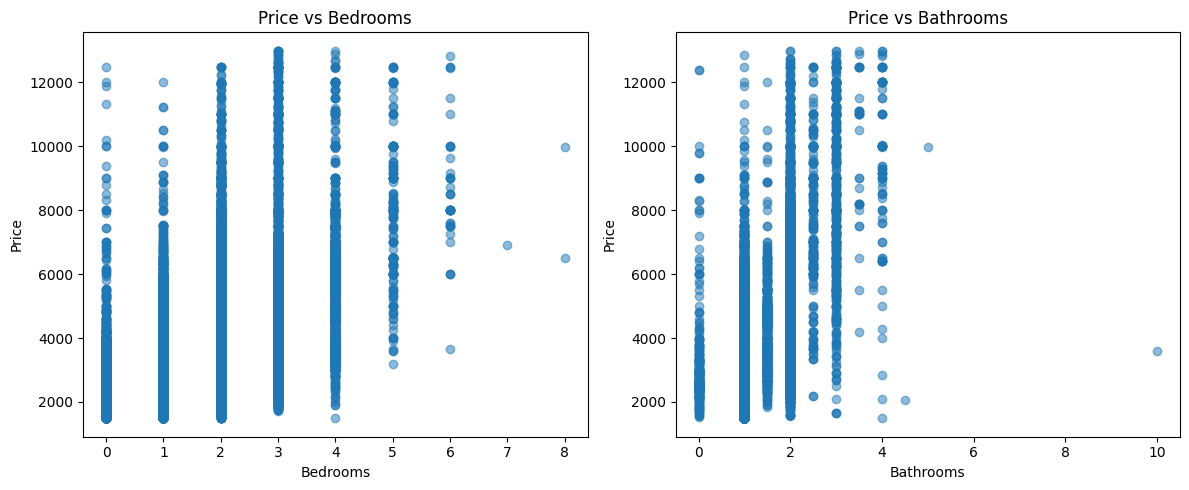

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df['bedrooms'], df['price'], alpha=0.5)
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.title('Price vs Bedrooms')

plt.subplot(1, 2, 2)
plt.scatter(df['bathrooms'], df['price'], alpha=0.5)
plt.xlabel('Bathrooms')
plt.ylabel('Price')
plt.title('Price vs Bathrooms')

plt.tight_layout()
plt.show()

In [35]:

outliers_8_bedrooms = df[df['bedrooms'] > 6]

print("Информация о выбросах по спальням:")
print(outliers_8_bedrooms[['price', 'bedrooms', 'bathrooms', 'latitude', 'longitude']])


Информация о выбросах по спальням:
        price  bedrooms  bathrooms  latitude  longitude
11313    6500         8        4.0   40.6881   -73.9553
28722    9995         8        3.0   40.6764   -73.9767
104687   6923         7        3.0   40.6761   -73.9459
